<a href="https://colab.research.google.com/github/Norwicklee/Workspace/blob/main/Unet_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# prompt: unzip /content/Segmentation.zip

!unzip /content/Segmentation.zip


Archive:  /content/Segmentation.zip
replace Segmentation/Ground Truth/20240422_110210_mask.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Segmentation/Ground Truth/20240422_110210_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110256_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110340_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110400_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110413_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110428_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110439_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110450_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110502_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110514_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110533_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110542_mask.jpg  
  inflating: Segmentation/Ground Truth/20240422_110604_mask.jpg  
  infl

In [47]:
!pip install torch torchvision albumentations segmentation-models-pytorch ternausnet
!apt-get install -qq nvidia-smi


E: Package 'nvidia-smi' has no installation candidate


In [48]:
import os
import numpy as np
import torch
import albumentations as A
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU
import cv2
from matplotlib import pyplot as plt
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score, accuracy_score


In [49]:
class SlapScanDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask


In [50]:
transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], is_check_shapes=False)


In [52]:
train_images_path = '/content/Segmentation/Training_Images/'
train_masks_path = '/content/Segmentation/Ground Truth/'

# Check if directories exist
def check_directory_exists(directory):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"The directory {directory} does not exist.")

check_directory_exists(train_images_path)
check_directory_exists(train_masks_path)

# Load dataset
full_dataset = SlapScanDataset(train_images_path, train_masks_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)


In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
metrics = [IoU()]


In [56]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

def train_model(model, train_loader, val_loader, loss_fn, metrics, optimizer, scheduler, device, num_epochs=10):
    best_iou = 0.0
    iou_metric = metrics[0] # Access the function within the list
    early_stopping_counter = 0
    best_model_path = 'best_model.pth'

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss = 0.0
        val_iou_scores = []
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks.unsqueeze(1).float())

                val_loss += loss.item()
                val_iou_scores.append(iou_metric(outputs, masks.unsqueeze(1).float()).item())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_iou = sum(val_iou_scores) / len(val_iou_scores)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')

        # Update learning rate scheduler
        scheduler.step(val_iou)

        # Early stopping based on validation IoU
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), best_model_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= 5:  # Adjust patience as needed
                print(f'Early stopping at epoch {epoch+1} with best IoU: {best_iou:.4f}')
                break

    print(f'Best validation IoU: {best_iou:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [57]:
train_model(model, train_loader, val_loader, loss_fn, metrics, optimizer, scheduler, device=device, num_epochs=10)


Epoch 1/10, Train Loss: -13.1377, Val Loss: -100.9604, Val IoU: 0.0000
Epoch 2/10, Train Loss: -25.5331, Val Loss: -0.0931, Val IoU: 0.3281
Epoch 3/10, Train Loss: -36.9704, Val Loss: -9.8086, Val IoU: 1.6900
Epoch 4/10, Train Loss: -47.7652, Val Loss: -79.7667, Val IoU: 46.4152
Epoch 5/10, Train Loss: -60.0935, Val Loss: -58.3588, Val IoU: 40.7730
Epoch 6/10, Train Loss: -73.5269, Val Loss: -61.3365, Val IoU: 12.6206
Epoch 7/10, Train Loss: -86.0045, Val Loss: -96.7061, Val IoU: 64.6902
Epoch 8/10, Train Loss: -101.1753, Val Loss: -143.3875, Val IoU: 25.7806
Epoch 9/10, Train Loss: -117.1135, Val Loss: -134.8552, Val IoU: 11.7410
Epoch 10/10, Train Loss: -134.4135, Val Loss: -115.3212, Val IoU: 4.6846
Best validation IoU: 64.6902


In [58]:
# Get a batch of validation data
val_images, val_masks = next(iter(val_loader))

# Move images to the device
val_images = val_images.to(device)

# Set the model to evaluation mode
model.eval()

# Generate predictions
with torch.no_grad():
    predictions = model(val_images)
    predictions = torch.sigmoid(predictions)  # Apply sigmoid to get probabilities
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary masks

# Move data back to CPU for visualization
val_images = val_images.cpu()
val_masks = val_masks.cpu()
predictions = predictions.cpu()


In [59]:
# Get a batch of validation data
val_images, val_masks = next(iter(val_loader))

# Move images to the device
val_images = val_images.to(device)

# Set the model to evaluation mode
model.eval()

# Generate predictions
with torch.no_grad():
    predictions = model(val_images)
    predictions = torch.sigmoid(predictions)  # Apply sigmoid to get probabilities
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary masks

# Move data back to CPU for visualization
val_images = val_images.cpu()
val_masks = val_masks.cpu()
predictions = predictions.cpu()


In [62]:
import matplotlib.pyplot as plt

def plot_segmentation_results(original_images, ground_truth_masks, predicted_masks, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Display original image
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(original_images[i].permute(1, 2, 0))  # Assuming images are in torch.Tensor format
        plt.title('Original Image')
        plt.axis('off')

        # Display ground truth mask
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(ground_truth_masks[i], cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Display predicted mask
        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')  # Squeeze to remove singleton dimension
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


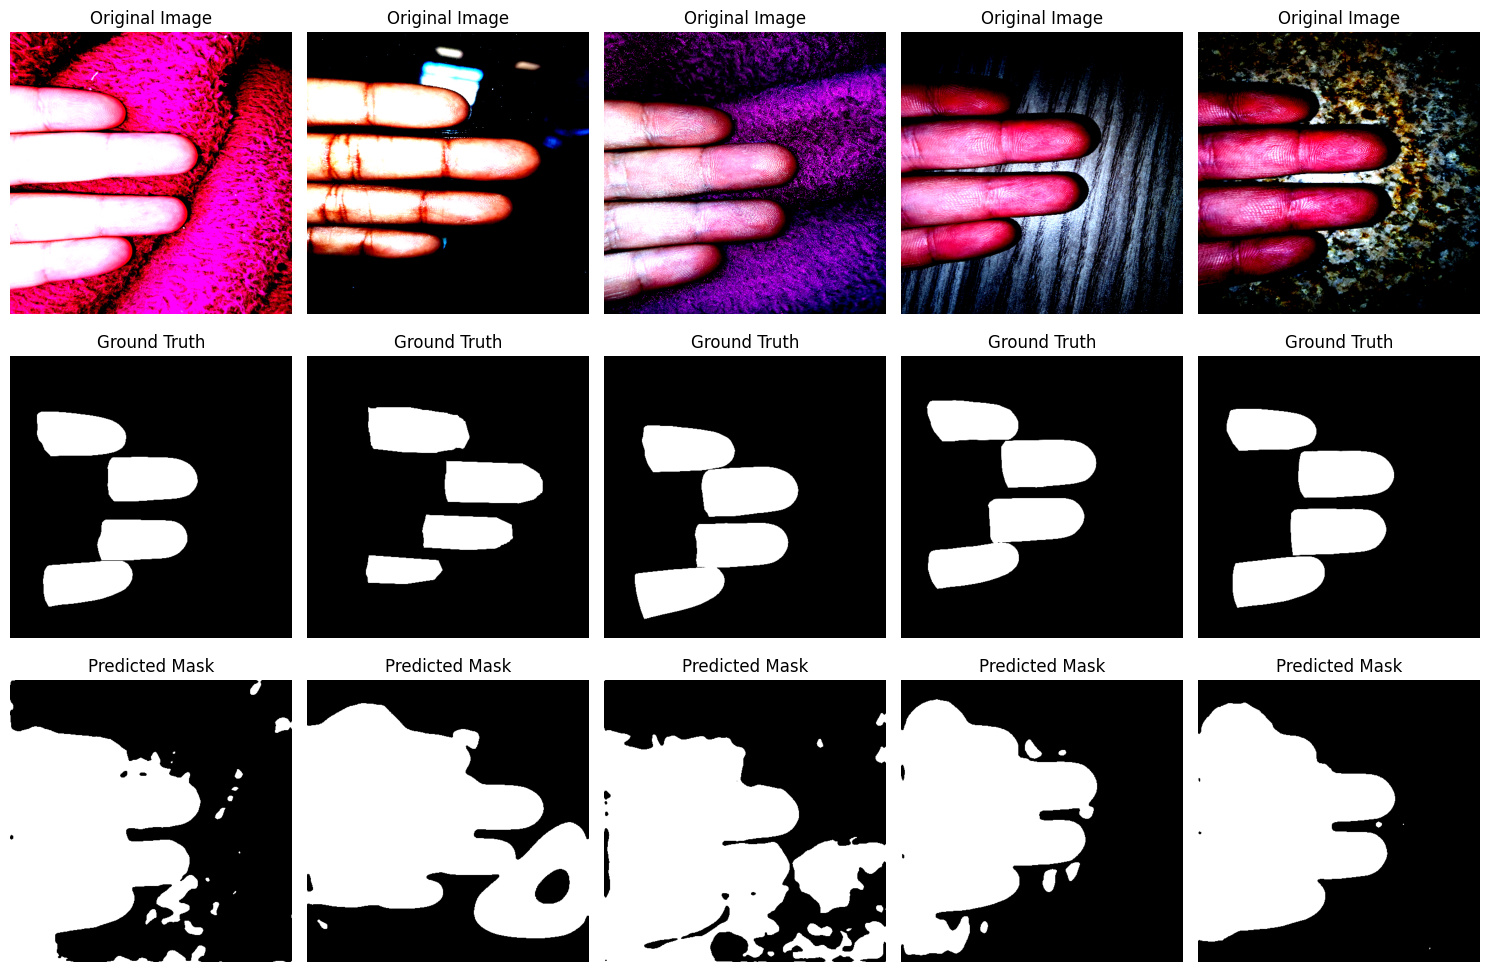

In [63]:
# Display the results
plot_segmentation_results(val_images, val_masks, predictions, num_samples=5)
